## Centrality Dependence of Shadowing

### Setup, Import & Preprocess

In [1]:
# === setup & imports ===
import os, sys, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

sys.path.append("./code")

# npdf modules
from npdf_module import (
    # datasets & analysis
    NPDFSystem, RpAAnalysis,
    # plotting
    style_axes, step_band_xy, slice_nearest_pt_for_each_y,
    band_xy, step_band_from_centers, step_band_from_left_edges, centers_to_left_edges,
    plot_rpa_vs_centrality_hzerr,
    # centrality
    WoodsSaxonPb, CentralityModel, GluonFromGrid, GluonRatioTable,
    # optional reader
    read_topdrawer,
)

plt.rcParams.update({"figure.figsize": (7.0, 5.0), "axes.grid": True})

# inputs
pPb5_dir = "./input/npdf/pPb5TeV"
pPb8_dir = "./input/npdf/pPb8TeV"

# energy-dependent inelastic NN cross section (mb)
sigmaNN_mb5 = 67.0
sigmaNN_mb8 = 71.0

# centrality edges (%)
cent_edges = [0,20,40,60,80,100]

# bin widths
dy  = 0.5
dpt = 2.5
pt_max_plot = 20.0

# outputs
out5 = "./output-5.02-centrality"; os.makedirs(out5, exist_ok=True)
out8 = "./output-8.16-centrality"; os.makedirs(out8, exist_ok=True)

In [2]:
## inputs
pPb5_dir = Path("./input/npdf/pPb5TeV/")
pPb8_dir = Path("./input/npdf/pPb8TeV/")

plt.rcParams.update({"figure.figsize": (7.0, 5.0), "axes.grid": True})

# energy-dependent inelastic NN cross section (mb)
sigmaNN_mb5 = 67.0
sigmaNN_mb8 = 71.0

# centrality edges (%)
cent_edges = [0,20,40,60,80,100]

# bin widths
dy  = 0.5
dpt = 2.5
pt_max_plot = 20.0

In [5]:
# 1) Load systems and build RpA(y, pT) with Hessian bands
ana = RpAAnalysis()

sys5 = NPDFSystem.from_folder(pPb5_dir, kick="pp", name="p+Pb 5.02 TeV")
rgrid5 = ana.compute_rpa_grid(sys5.df_pp, sys5.df_pa, sys5.df_errors, join="intersect")
print("5.02 TeV RpA grid:", rgrid5.shape)

sys8 = NPDFSystem.from_folder(pPb8_dir, kick="pp", name="p+Pb 8.16 TeV")
rgrid8 = ana.compute_rpa_grid(sys8.df_pp, sys8.df_pa, sys8.df_errors, join="intersect")
print("8.16 TeV RpA grid:", rgrid8.shape)

5.02 TeV RpA grid: (2000, 5)
8.16 TeV RpA grid: (2000, 5)


### Without Centrality

In [6]:
systems = [("5.02", sys5, rgrid5), ("8.16", sys8, rgrid8)]

outdir = "output"

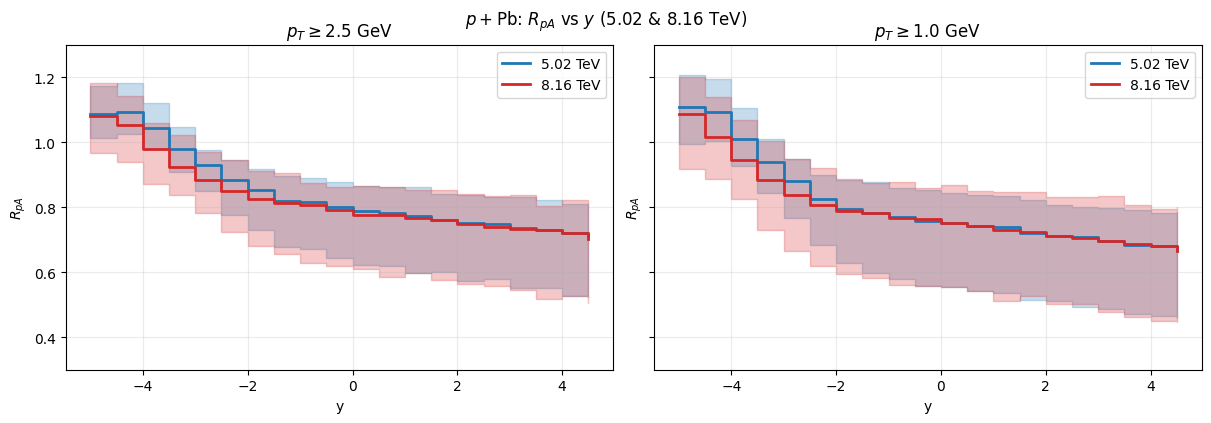

In [47]:
# RpA vs y: 5.02 & 8.16 TeV on one figure
# LEFT panel:  pT >= 2.5 GeV
# RIGHT panel: pT >= 1.0 GeV

pairs = [("5.02", sys5, rgrid5), ("8.16", sys8, rgrid8)]

# compute once
results = {}
for tag, sysX, rgrid in pairs:
    df_1p0  = ana.rpa_vs_y_pt_threshold(rgrid, sysX.df_pa, pt_min=1.0)
    df_2p5  = ana.rpa_vs_y_pt_threshold(rgrid, sysX.df_pa, pt_min=2.5)
    results[(tag, "1.0")] = (df_1p0, sysX)
    results[(tag, "2.5")] = (df_2p5, sysX)

def _x_edges(sysX, df):
    # keep your original edge logic, but robust
    if getattr(sysX, "y_edges", None) is not None and len(sysX.y_edges) == len(df):
        return sysX.y_edges.values
    return centers_to_left_edges(df["y"].values)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4),
                         sharex=True, sharey=True, constrained_layout=True)

# panel specs: left=2.5, right=1.0
panel_specs = [("2.5", r"$p_T \geq 2.5$ GeV"),
               ("1.0", r"$p_T \geq 1.0$ GeV")]

# consistent colors per energy
colors = {"5.02": "tab:blue", "8.16": "tab:red"}

for ax, (ptkey, panel_title) in zip(axes, panel_specs):
    for tag in ["5.02", "8.16"]:
        df, sysX = results[(tag, ptkey)]
        x = _x_edges(sysX, df)
        step_band_xy(ax, x,
                     df["r_central"], df["r_lo"], df["r_hi"],
                     label=f"{tag} TeV", color=colors[tag])
    style_axes(ax, "y", r"$R_{pA}$", title=panel_title)
    ax.set_ylim(0.3, 1.3)
    ax.legend()

fig.suptitle(r"$p+$Pb: $R_{pA}$ vs $y$ (5.02 & 8.16 TeV)", y=1.02, fontsize=12)
plt.show()

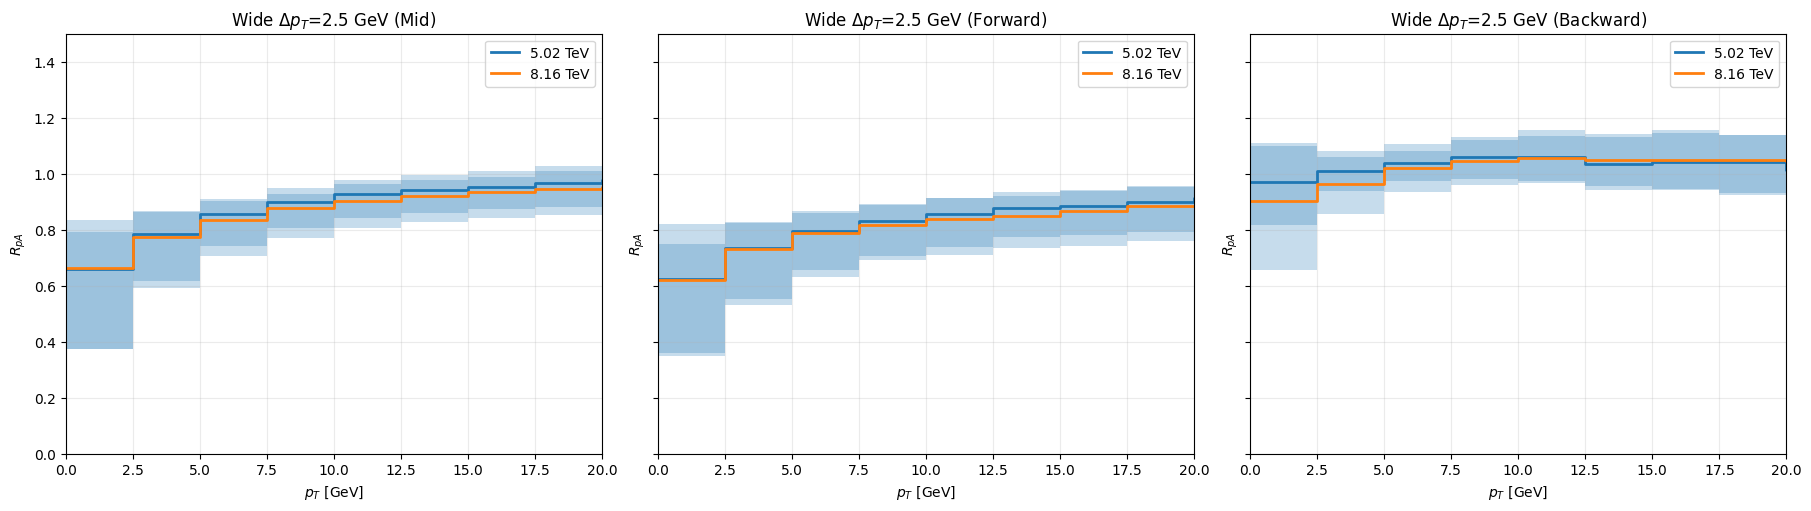

In [48]:
# --- MODIFICATION 1: Remove the "200" system from the list ---
# Only include the systems you want to plot.
y_windows = [(-1.93, 1.93, "Mid"),  # CMS
             ( 1.5,  4.0, "Forward"),
             (-5.0, -2.5, "Backward")]


# --- MODIFICATION 2: Create a single row of subplots ---
# The number of rows is now 1, to overlay the plots.
n_windows = len(y_windows)
fig, axes = plt.subplots(nrows=1, ncols=n_windows, figsize=(6 * n_windows, 5),
                         sharex=True, sharey=True, constrained_layout=True)

# --- MODIFICATION 3: Handle the case of a single plot ---
# If n_windows is 1, `axes` is not an array. This makes it iterable.
if n_windows == 1:
    axes = [axes]

# --- MODIFICATION 4: Restructure the loops ---
# Loop over the plot columns (y_windows) first, then over the systems.
for j, (ymin, ymax, name) in enumerate(y_windows):
    ax = axes[j]  # Select the current subplot

    # Loop through each system (5.02 and 8.16) and plot it on the *same* axis `ax`
    for tag, sysX, rgrid in systems:
        # Compute the data for the current system
        wide = ana.rpa_vs_pt_widebins(rgrid, sysX.df_pa, y_min=ymin, y_max=ymax, width=2.5)
        
        # Plot on the current subplot, using the system tag for the legend
        step_band_from_left_edges(ax, wide["pt_left"], wide["r_central"], wide["r_lo"], wide["r_hi"],
                                  label=f"{tag} TeV")

    # Style the axes *after* both systems have been plotted
    # The title is now more general since it contains multiple systems.
    style_axes(ax, r"$p_T$ [GeV]", r"$R_{pA}$", title=f"Wide Δ$p_T$=2.5 GeV ({name})")
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 1.5)
    ax.legend()  # Create the legend, which will now show "5.02 TeV" and "8.16 TeV"

# Display the figure
plt.show()

### Gluon Ratio

In [49]:
## Gluon Ratio
import glob

def build_SA_provider(energy_tag, sys_npds, sqrt_sNN_GeV, verbose=True):
    """
    energy_tag: '5TeV' or '8TeV'
    sys_npds:   the NPDFSystem for that energy (has df_pp/df_pa)
    """
    folder = Path(f"./input/gluon_ratio/{energy_tag}")
    cand = sorted(glob.glob(str(folder / "*.tsv"))) + sorted(glob.glob(str(folder / "*.csv")))
    if cand:
        if verbose: print(f"[S_A] using table file: {cand[0]}")
        return GluonRatioTable(Path(cand[0]), sqrt_sNN_GeV=float(sqrt_sNN_GeV)).load()
    if verbose: print(f"[S_A] no table in {folder} → fallback to σ_pA/σ_pp grid")
    return GluonFromGrid(sys_npds.df_pp, sys_npds.df_pa)

# 5.02 TeV
# build S_A providers exactly as before
SA5 = build_SA_provider("5TeV", sys5, sqrt_sNN_GeV=5020.0)  # finds your 4-col file
# 8.16 TeV
SA8 = build_SA_provider("8TeV", sys8, sqrt_sNN_GeV=8160.0)

[S_A] no table in input/gluon_ratio/5TeV → fallback to σ_pA/σ_pp grid
[S_A] no table in input/gluon_ratio/8TeV → fallback to σ_pA/σ_pp grid


In [52]:
# # heatmap: ⟨S_A(y,pT)⟩ per (Δy=0.5, ΔpT=2.5) bin
# y_edges  = np.arange(-5.0, 5.0+0.5, 0.5)
# pt_edges = np.arange(0.0, 30.0+2.5, 2.5)

# rows = []
# for i in range(len(y_edges)-1):
#     for j in range(len(pt_edges)-1):
#         ys = np.linspace(y_edges[i],   y_edges[i+1], 5)
#         ps = np.linspace(pt_edges[j], pt_edges[j+1], 5)
#         val = np.mean([SA5.SA_ypt(float(y), float(p)) for y in ys for p in ps])
#         rows.append([0.5*(y_edges[i]+y_edges[i+1]),
#                      0.5*(pt_edges[j]+pt_edges[j+1]),
#                      val])
# SA_grid = pd.DataFrame(rows, columns=["y","pt","SA"])

# pivot = SA_grid.pivot(index="y", columns="pt", values="SA")
# plt.figure(figsize=(7,4))
# plt.imshow(pivot.values, origin="lower", aspect="auto",
#            extent=[pt_edges[0], pt_edges[-1], y_edges[0], y_edges[-1]])
# plt.colorbar(label=r"$S_A(y,p_T)$"); plt.xlabel(r"$p_T$ [GeV]"); plt.ylabel("y"); plt.show()

In [17]:
geom   = WoodsSaxonPb()
model5 = CentralityModel.from_inputs(SA5, geom, b_max=12.0, nb=601)     # Nnorm from geometry
model8 = CentralityModel.from_inputs(SA8, geom, b_max=12.0, nb=601)

In [18]:
Nnorm = model5.Nnorm
print("N_A = ", Nnorm)
Nnorm8 = model8.Nnorm
print("N_A = ", Nnorm8)

N_A =  1.363836752898261
N_A =  1.363836752898261


In [19]:
cent_edges = [0, 20, 40, 60, 80, 100]
tbl5 = model5.centrality_table(cent_edges, sigmaNN_mb=sigmaNN_mb5)
tbl8 = model8.centrality_table(cent_edges, sigmaNN_mb=sigmaNN_mb8)
display(tbl5); display(tbl8)

,cent_bin,b_left,b_right,b_mean,alpha,N_part
0,0-20%,0.000000,3.532157,2.346704,0.922964,14.469940
1,20-40%,3.532157,4.995260,4.300573,0.741329,11.888996
2,40-60%,4.995260,6.118944,5.567898,0.501566,8.429215
3,60-80%,6.118944,7.110770,6.610540,0.234338,4.503651
4,80-100%,7.110770,12.000000,7.897046,0.053286,1.801815


,cent_bin,b_left,b_right,b_mean,alpha,N_part
0,0-20%,0.000000,3.548752,2.360037,0.922023,15.231829
1,20-40%,3.548752,5.018724,4.320386,0.738454,12.477169
2,40-60%,5.018724,6.147440,5.598506,0.493996,8.747367
3,60-80%,6.147440,7.141239,6.650531,0.224855,4.561897
4,80-100%,7.141239,12.000000,7.934062,0.050273,1.801646


#### Centrality Info

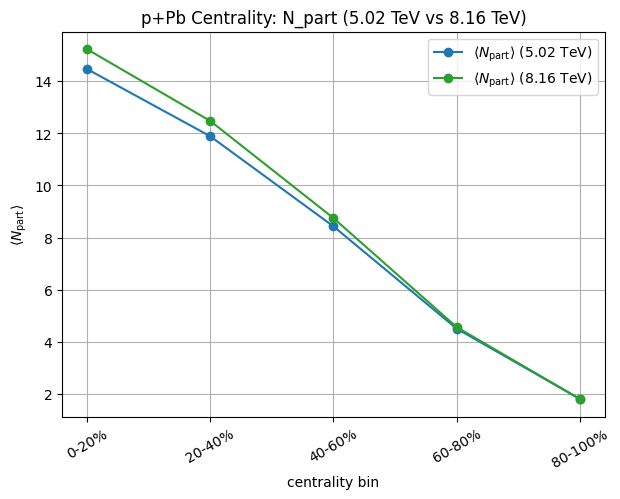

In [20]:
def centrality_meta(model5, model8, edges, sigmaNN_mb5=67, sigmaNN_mb8=71):
    # Calculate centrality tables for both energies
    ctab5 = model5.centrality_table(edges, sigmaNN_mb=sigmaNN_mb5)
    ctab8 = model8.centrality_table(edges, sigmaNN_mb=sigmaNN_mb8)

    # Plot 1: N_part for both energies
    fig1, ax1 = plt.subplots()
    ax1.plot(ctab5["cent_bin"], ctab5["N_part"], "o-", label=r"$\langle N_{\rm part}\rangle$ (5.02 TeV)", color="tab:blue")
    ax1.plot(ctab8["cent_bin"], ctab8["N_part"], "o-", label=r"$\langle N_{\rm part}\rangle$ (8.16 TeV)", color="tab:green")
    ax1.set_xlabel("centrality bin")
    ax1.set_ylabel(r"$\langle N_{\rm part}\rangle$")
    ax1.set_title("p+Pb Centrality: N_part (5.02 TeV vs 8.16 TeV)")
    plt.setp(ax1.get_xticklabels(), rotation=30)
    ax1.legend(loc="upper right")
    plt.show()

    # # Plot 2: T/T0 for both energies
    # fig2, ax2 = plt.subplots()
    # ax2.plot(ctab5["cent_bin"], ctab5["alpha"], "s--", label=r"$\langle T/T_0\rangle$ (5.02 TeV)", color="tab:orange")
    # ax2.plot(ctab8["cent_bin"], ctab8["alpha"], "s--", label=r"$\langle T/T_0\rangle$ (8.16 TeV)", color="tab:red")
    # ax2.set_xlabel("centrality bin")
    # ax2.set_ylabel(r"$\langle T/T_0\rangle$")
    # ax2.set_title("p+Pb Centrality: T/T0 (5.02 TeV vs 8.16 TeV)")
    # plt.setp(ax2.get_xticklabels(), rotation=30)
    # ax2.legend(loc="upper right")
    # plt.show()

    return ctab5, ctab8

# Call the function
ctab5, ctab8 = centrality_meta(model5, model8, cent_edges)

#### Gluon Ratio in Binned

In [21]:
def _edges_from_width(vals, width):
    v = np.asarray(vals, float)
    a = width * np.floor(np.nanmin(v) / width)
    b = width * np.ceil (np.nanmax(v) / width) + 1e-12
    return np.arange(a, b, width)

def _weighted_mean(x, w):
    x = np.asarray(x, float)
    w = np.clip(np.asarray(w, float), 0, None)
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    return np.nan if not np.any(m) else float(np.sum(x[m]*w[m])/np.sum(w[m]))

def make_SA_grid(model, rgrid, verbose=True):
    rg = model.attach_SA_to_grid(rgrid, verbose=verbose).copy()
    if rg["SA"].isna().any():
        # conservative fill; keeps flow going
        rg["SA"] = rg["SA"].fillna(1.0)
    return rg

def SA_vs_y_binned(model, rgrid, pa_df=None, y_width=0.5, pt_min=2.5,
                   winsor_pct=0.0, verbose=False):
    rg = make_SA_grid(model, rgrid, verbose=verbose)
    g  = rg[rg["pt"] >= pt_min][["y","pt","SA"]].copy()
    if g.empty: return pd.DataFrame(columns=["y_left","y_right","y","SA"])
    y_edges = _edges_from_width(g["y"], y_width)
    g["ybin"] = np.digitize(g["y"].to_numpy(), y_edges) - 1

    # attach weights if provided; else 1.0
    if (pa_df is not None) and set(["y","pt","val"]).issubset(pa_df.columns):
        wtbl = pa_df[["y","pt","val"]].rename(columns={"val":"w"})
        g = g.merge(wtbl, on=["y","pt"], how="left")
    if "w" not in g.columns:
        g["w"] = 1.0

    if winsor_pct and 0 < winsor_pct < 0.5:
        chunks = []
        for _, dfb in g.groupby("ybin", sort=True):
            lo, hi = np.nanquantile(dfb["SA"], [winsor_pct, 1 - winsor_pct])
            dfb = dfb.copy(); dfb["SA"] = np.clip(dfb["SA"], lo, hi); chunks.append(dfb)
        g = pd.concat(chunks, ignore_index=True)

    rows=[]
    for b in sorted(g["ybin"].unique()):
        sub = g[g["ybin"]==b]
        yl, yr = y_edges[b], y_edges[b+1]
        rows.append({"y_left":yl, "y_right":yr, "y":0.5*(yl+yr),
                     "SA": _weighted_mean(sub["SA"], sub["w"])})
    return pd.DataFrame(rows).sort_values("y_left").reset_index(drop=True)

def SA_vs_pt_binned(model, rgrid, y_min, y_max, pt_width=2.5, pa_df=None,
                    winsor_pct=0.0, verbose=False):
    rg = make_SA_grid(model, rgrid, verbose=verbose)
    g  = rg[(rg["y"]>=y_min)&(rg["y"]<=y_max)][["y","pt","SA"]].copy()
    if g.empty: return pd.DataFrame(columns=["pt_left","pt_right","pt","SA"])
    pt_edges = _edges_from_width(g["pt"], pt_width)
    g["ptbin"] = np.digitize(g["pt"].to_numpy(), pt_edges) - 1

    if (pa_df is not None) and set(["y","pt","val"]).issubset(pa_df.columns):
        wtbl = pa_df[["y","pt","val"]].rename(columns={"val":"w"})
        g = g.merge(wtbl, on=["y","pt"], how="left")
    if "w" not in g.columns:
        g["w"] = 1.0

    if winsor_pct and 0 < winsor_pct < 0.5:
        def _wins(df, col):
            ql, qh = np.nanquantile(df[col], [winsor_pct, 1-winsor_pct])
            return df.assign(**{col: np.clip(df[col], ql, qh)})
        g = g.groupby("ptbin", group_keys=False).apply(_wins, "SA")

    rows=[]
    for b in sorted(g["ptbin"].unique()):
        sub = g[g["ptbin"]==b]
        pl, pr = pt_edges[b], pt_edges[b+1]
        rows.append({"pt_left":pl, "pt_right":pr, "pt":0.5*(pl+pr),
                     "SA": _weighted_mean(sub["SA"], sub["w"])})
    return pd.DataFrame(rows).sort_values("pt_left").reset_index(drop=True)

In [53]:
# # diagnostics: SA vs y at pt≈2.5 and SA vs pT at y≈0.25
# rg5_sa = model5.attach_SA_to_grid(rgrid5, verbose=True)
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
# pt_target = 5.0
# sli = rg5_sa.groupby("y", group_keys=False).apply(lambda g: g.iloc[(g["pt"]-pt_target).abs().argmin()])
# ax1.plot(sli["y"], sli["SA"], "o-"); style_axes(ax1, "y", r"$S_A(y,p_T\approx 5.0 \,{\rm GeV})$", "S_A diagnostics")
# y_target = 0.25
# sli2 = rg5_sa.groupby("pt", group_keys=False).apply(lambda g: g.iloc[(g["y"]-y_target).abs().argmin()])
# ax2.plot(sli2["pt"], sli2["SA"], "o-"); style_axes(ax2, r"$p_T$ [GeV]", r"$S_A(y\approx 0.25,p_T)$")
# plt.tight_layout(); plt.show()

/tmp/ipykernel_68982/1655541318.py:68: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g = g.groupby("ptbin", group_keys=False).apply(_wins, "SA")


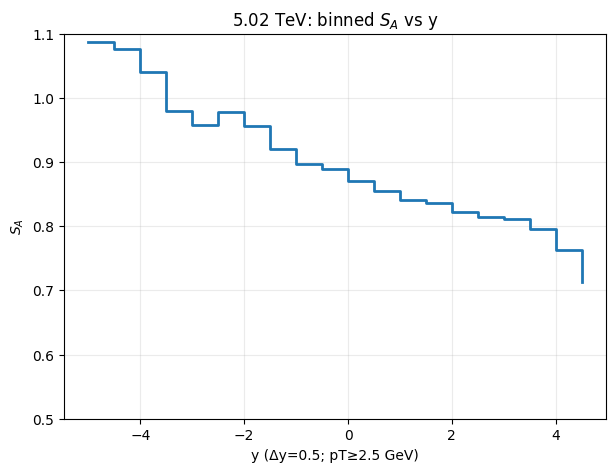

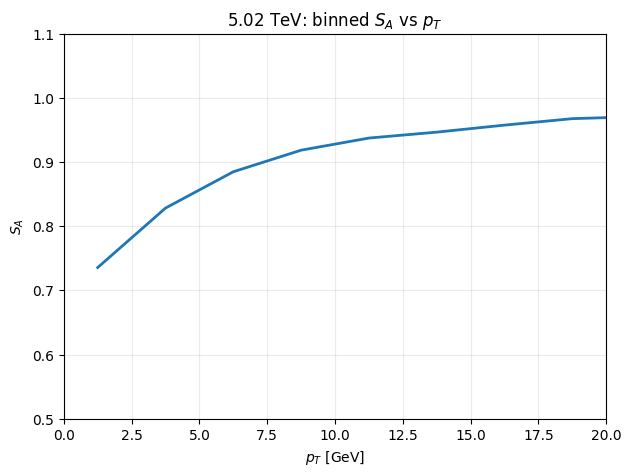

In [23]:
# binned SA
tab_SA_y  = SA_vs_y_binned(model5, rgrid5, pa_df=sys5.df_pa, y_width=dy,  pt_min=2.5, winsor_pct=0.10)
tab_SA_pt = SA_vs_pt_binned(model5, rgrid5, y_min=-5, y_max=5, pt_width=dpt, pa_df=sys5.df_pa, winsor_pct=0.10)

fig, ax = plt.subplots(); step_band_xy(ax, tab_SA_y["y_left"], tab_SA_y["SA"], tab_SA_y["SA"], tab_SA_y["SA"])
style_axes(ax, f"y (Δy={dy}; pT≥2.5 GeV)", r"$S_A$", title="5.02 TeV: binned $S_A$ vs y"); ax.set_ylim(0.5,1.1); plt.show()

fig, ax = plt.subplots(); band_xy(ax, tab_SA_pt["pt"], tab_SA_pt["SA"], tab_SA_pt["SA"], tab_SA_pt["SA"])
style_axes(ax, r"$p_T$ [GeV]", r"$S_A$", title="5.02 TeV: binned $S_A$ vs $p_T$"); ax.set_xlim(0,20); ax.set_ylim(0.5,1.1); plt.show()

In [24]:
# --- helpers (unchanged logic, tiny robustness) ---
def make_SA_grid(model, rgrid, verbose=True):
    rg = model.attach_SA_to_grid(rgrid, verbose=verbose).copy()
    # collapse any accidental duplicate column names (keep last)
    if rg.columns.duplicated().any():
        rg = rg.loc[:, ~rg.columns.duplicated(keep="last")]
    if rg["SA"].isna().any():
        rg["SA"] = rg["SA"].fillna(1.0)
    return rg


# --------- S_AWS vs y and vs pT by centrality ---------
def SAWS_vs_y_by_centrality(model, rgrid, pa_df, cent_edges,
                             y_width=0.5, pt_min=2.5,
                             sigmaNN_mb=70.0, weight="inelastic",
                             winsor_pct=0.0, verbose=False):
    rg = make_SA_grid(model, rgrid, verbose=verbose)
    ctab = model.centrality_table(cent_edges, sigmaNN_mb=sigmaNN_mb)
    amap = {row["cent_bin"]: float(row["alpha"]) for _, row in ctab.iterrows()}
    out = []
    for label, alpha in amap.items():
        g = rg.copy()
        g["SAWS"] = 1.0 + model.Nnorm * (g["SA"] - 1.0) * alpha
        # shim: *overwrite* SA with SAWS and expose only y,pt,SA (no duplicates)
        tmp_model = type("Tmp", (), {
            "attach_SA_to_grid": (lambda self, r, verbose=False:
                                  g.assign(SA=g["SAWS"])[["y","pt","SA"]].copy())
        })()
        ytab = SA_vs_y_binned(tmp_model, g, pa_df=pa_df,
                              y_width=y_width, pt_min=pt_min,
                              winsor_pct=winsor_pct, verbose=False
                              ).rename(columns={"SA":"SAWS"})
        out.append((label, ytab))
    return out


def SAWS_vs_pt_by_centrality(model, rgrid, pa_df, cent_edges,
                             y_min, y_max, pt_width=2.5,
                             sigmaNN_mb=70.0, weight="inelastic",
                             winsor_pct=0.0, verbose=False):
    rg = make_SA_grid(model, rgrid, verbose=verbose)
    ctab = model.centrality_table(cent_edges, sigmaNN_mb=sigmaNN_mb)
    amap = {row["cent_bin"]: float(row["alpha"]) for _, row in ctab.iterrows()}
    out = []
    for label, alpha in amap.items():
        g = rg.copy()
        g["SAWS"] = 1.0 + model.Nnorm * (g["SA"] - 1.0) * alpha
        tmp_model = type("Tmp", (), {
            "attach_SA_to_grid": (lambda self, r, verbose=False:
                                  g.assign(SA=g["SAWS"])[["y","pt","SA"]].copy())
        })()
        pttab = SA_vs_pt_binned(tmp_model, g, y_min=y_min, y_max=y_max,
                                pt_width=pt_width, pa_df=pa_df,
                                winsor_pct=winsor_pct, verbose=False
                                ).rename(columns={"SA":"SAWS"})
        out.append((label, pttab))
    return out


# --------- S_AWS vs impact parameter (or N_part) ---------
def SAWS_vs_b(model, rgrid, pa_df, y_min, y_max, pt_min, pt_max,
              b_values=None, sigmaNN_mb=70.0, winsor_pct=0.0, verbose=False):
    """
    Returns a table of ⟨S_AWS(y,pT,b)⟩_weights for each b.
    Weights = σ_pA(y,pT) from pa_df. Also returns α(b)=T(b)/T(0) and N_part(b).
    """
    rg = model.attach_SA_to_grid(rgrid, verbose=verbose).copy()
    m  = (rg["y"]>=y_min)&(rg["y"]<=y_max)&(rg["pt"]>=pt_min)&(rg["pt"]<=pt_max)
    rg = rg.loc[m, ["y","pt","SA"]].copy()
    if rg.empty:
        return pd.DataFrame(columns=["b","alpha","N_part","SAWS"])

    # weights from σ_pA(y,pt)
    wtbl = pa_df[["y","pt","val"]].rename(columns={"val":"w"})
    rg   = rg.merge(wtbl, on=["y","pt"], how="left")
    rg["w"] = rg["w"].clip(lower=0).fillna(0.0)

    if winsor_pct and 0 < winsor_pct < 0.5:
        lo, hi = np.nanquantile(rg["SA"], [winsor_pct, 1-winsor_pct])
        rg["SA"] = np.clip(rg["SA"], lo, hi)

    if b_values is None:
        b_values = model.T_grid["b"].to_numpy()

    SA = np.where(np.isfinite(rg["SA"].to_numpy()) & (rg["SA"].to_numpy()>0), rg["SA"].to_numpy(), 1.0)
    w  = rg["w"].to_numpy()

    rows = []
    b_arr = np.asarray(b_values, float)
    b_T   = model.T_grid["b"].to_numpy()
    T_T   = model.T_grid["T"].to_numpy()
    T0    = float(T_T[0])

    for bv in b_arr:
        Tb     = float(np.interp(bv, b_T, T_T))
        alpha  = Tb/T0 if T0>0 else 0.0
        SAWS_k = 1.0 + model.Nnorm * (SA - 1.0) * alpha
        s      = w.sum()
        SAWS_w = float((SAWS_k*w).sum()/s) if s>0 else np.nan
        Np     = model.geom.Npart_pA(Tb, sigmaNN_mb=sigmaNN_mb)
        rows.append({"b": float(bv), "alpha": float(alpha),
                     "N_part": float(Np), "SAWS": SAWS_w})
    return pd.DataFrame(rows)


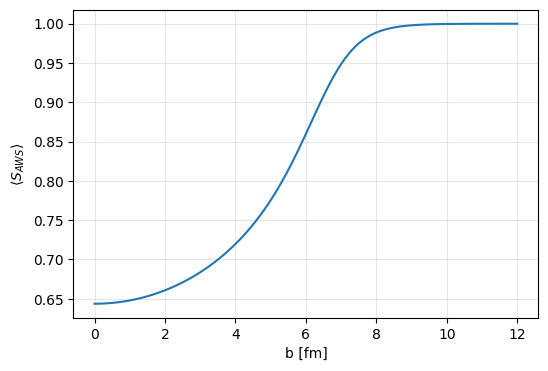

In [25]:
# S_AWS vs impact parameter (forward window as example)
b_vals = np.linspace(0, 12, 121)
tab_SAWS_b = SAWS_vs_b(model5, rgrid5, sys5.df_pa,
                       y_min=2.5, y_max=4.0, pt_min=2.5, pt_max=20.0,
                       b_values=b_vals, sigmaNN_mb=sigmaNN_mb5)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(tab_SAWS_b["b"], tab_SAWS_b["SAWS"])
ax.set_xlabel("b [fm]"); ax.set_ylabel(r"$\langle S_{AWS}\rangle$")
ax.grid(True, alpha=0.3)
plt.show()

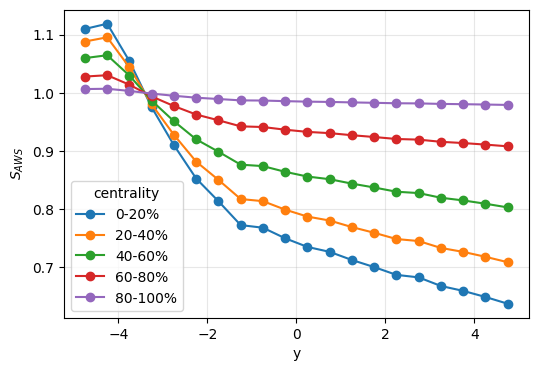

In [26]:
cent_edges = [0,20,40,60,80,100]

# S_AWS vs y (pT ≥ 2.5)
saws_y_tabs = SAWS_vs_y_by_centrality(model5, rgrid5, sys5.df_pa, cent_edges,
                                      y_width=0.5, pt_min=2.5,
                                      sigmaNN_mb=sigmaNN_mb5)

# Plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
for label, tab in saws_y_tabs:
    ax.plot(tab["y"], tab["SAWS"], marker="o", label=label)
ax.set_xlabel("y")
ax.set_ylabel(r"$S_{AWS}$")
ax.legend(title="centrality")
ax.grid(True, alpha=0.3)
plt.show()

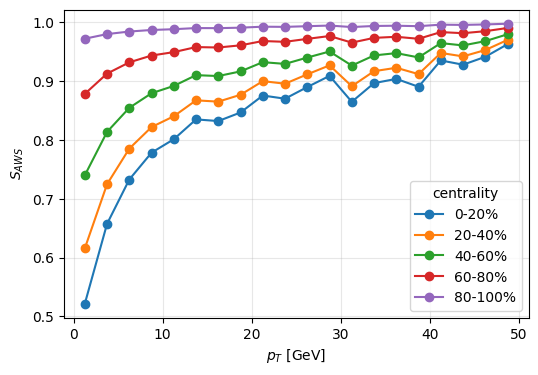

In [27]:
# S_AWS vs pT in forward (2.5 ≤ y ≤ 4.0)
saws_pt_tabs = SAWS_vs_pt_by_centrality(model5, rgrid5, sys5.df_pa, cent_edges,
                                        y_min=2.5, y_max=4.0, pt_width=2.5,
                                        sigmaNN_mb=sigmaNN_mb5)

fig, ax = plt.subplots(figsize=(6,4))
for label, tab in saws_pt_tabs:
    ax.plot(tab["pt"], tab["SAWS"], marker="o", label=label)
ax.set_xlabel(r"$p_T$ [GeV]")
ax.set_ylabel(r"$S_{AWS}$")
ax.legend(title="centrality")
ax.grid(True, alpha=0.3)
plt.show()

## RpA vs Centrality

### All Overlap

[rpa_vs_b] window: y∈[-5,4.0], pT∈[0.0,20.0]


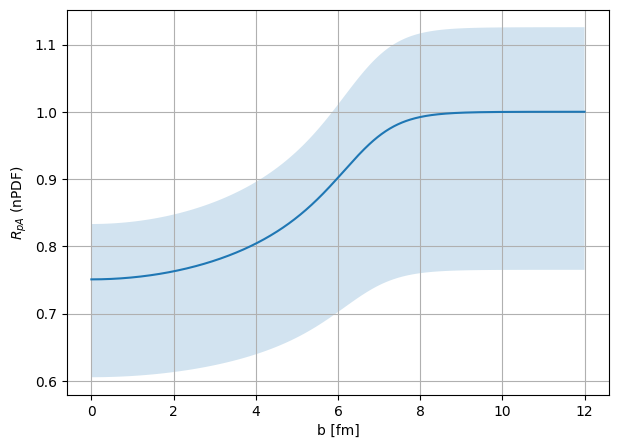

In [55]:
# assuming you already built rgrid5 = ana.compute_rpa_grid(...) and sys5.df_pa (as in your notebook)
res_b = model5.rpa_vs_b(
    rgrid=rgrid5, df_pa=sys5.df_pa,
    y_min=-5, y_max=4.0,        # CMS mid-rapidity
    pt_min=0.0,  pt_max=20.0,
    b_values=None,                  # use model's b grid
    sigmaNN_mb=sigmaNN_mb5,
    verbose=True
)
ax = res_b.plot(x="b", y="r_central", legend=False)
ax.fill_between(res_b["b"], res_b["r_lo"], res_b["r_hi"], alpha=0.2)
ax.set_xlabel("b [fm]"); ax.set_ylabel(r"$R_{pA}$ (nPDF)"); ax.grid(True)

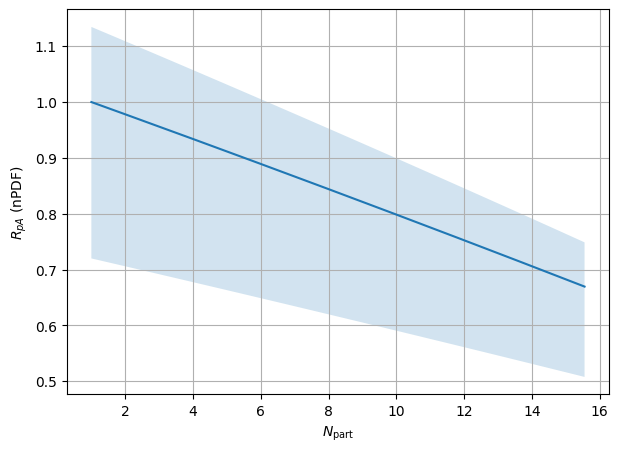

In [29]:
# Vs N_part:
ax2 = res_b.plot(x="N_part", y="r_central", legend=False)
ax2.fill_between(res_b["N_part"], res_b["r_lo"], res_b["r_hi"], alpha=0.2)
ax2.set_xlabel(r"$N_{\rm part}$"); ax2.set_ylabel(r"$R_{pA}$ (nPDF)"); ax2.grid(True)

In [30]:
# --- helper: generic "one panel per centrality" from the bands list ---
def _show_bands_grid(bands, *, xcol, xlabel, step=False, xlim=None, ylim=(0.3,1.3),
                     ncols=3, suptitle=None):
    # keep only non-empty bins (order preserved)
    bands = [(lab, df.copy()) for (lab, df) in bands if not df.empty]
    if not bands:
        print("[warn] no centrality bands to plot"); return

    n = len(bands)
    ncols = min(ncols, n)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5.2*ncols, 3.8*nrows),
                             sharex=True, sharey=True, constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    for ax, (label, df) in zip(axes, bands):
        if step:
            # step bands expect "left edges" on the x-axis
            step_band_xy(ax, df[xcol], df["r_central"], df["r_lo"], df["r_hi"])
        else:
            band_xy(ax, df[xcol], df["r_central"], df["r_lo"], df["r_hi"])
        style_axes(ax, xlabel, r"$R_{pA}$", title=label)
        if xlim: ax.set_xlim(*xlim)
        if ylim: ax.set_ylim(*ylim)

    # hide unused slots
    for ax in axes[len(bands):]:
        ax.axis("off")

    if suptitle:
        fig.suptitle(suptitle)
    plt.show()

In [31]:
# RpA vs centrality (one number per bin), in physics windows
def rpa_vs_cent_table(model, rgrid, pa_df, ywin, ptmin, ptmax, out_dir, tag, name, sigmaNN_mb):
    tab = model.rpa_vs_centrality_integrated(
        rgrid, pa_df, cent_edges,
        y_min=ywin[0], y_max=ywin[1], pt_min=ptmin, pt_max=ptmax,
        sigmaNN_mb=sigmaNN_mb, weight="inelastic", verbose=True
    )
    if tab.empty:
        print(f"[warn] {tag} {name} returned empty"); return tab
    fn = os.path.join(out_dir, f"RpA_vs_centrality_{name}_y{ywin[0]}to{ywin[1]}_pt{ptmin}to{ptmax}.csv")
    tab.to_csv(fn, index=False)

    fig, ax = plt.subplots()
    xs = np.arange(len(tab))
    y  = tab["r_central"].to_numpy()
    ylo = y - tab["r_lo"].to_numpy()
    yhi = tab["r_hi"].to_numpy() - y
    ax.errorbar(xs, y, yerr=[ylo, yhi], fmt="o", capsize=3, lw=1.2)
    ax.set_xticks(xs, tab["cent_bin"])
    style_axes(ax, "centrality bin", r"$R_{pA}$", title=f"{tag}: RpA vs centrality ({name})")
    ax.set_ylim(0.3, 1.5); plt.xticks(rotation=30); plt.show()
    return tab

[rpa_vs_centrality_integrated] window: y∈[-1.93,1.93], pT∈[2.5,20.0]
  bin 0-20%: alpha=0.922964, points=280, wsum=3.587e+02
  bin 20-40%: alpha=0.741329, points=280, wsum=3.587e+02
  bin 40-60%: alpha=0.501566, points=280, wsum=3.587e+02
  bin 60-80%: alpha=0.234338, points=280, wsum=3.587e+02
  bin 80-100%: alpha=0.053286, points=280, wsum=3.587e+02


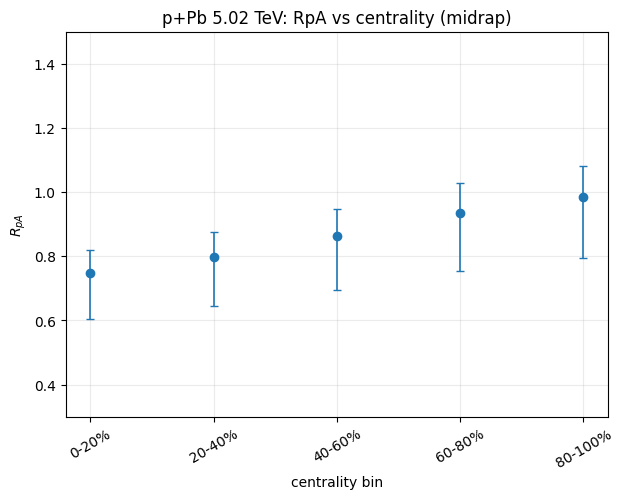

[rpa_vs_centrality_integrated] window: y∈[-1.93,1.93], pT∈[2.5,20.0]
  bin 0-20%: alpha=0.922023, points=280, wsum=4.884e+02
  bin 20-40%: alpha=0.738454, points=280, wsum=4.884e+02
  bin 40-60%: alpha=0.493996, points=280, wsum=4.884e+02
  bin 60-80%: alpha=0.224855, points=280, wsum=4.884e+02
  bin 80-100%: alpha=0.050273, points=280, wsum=4.884e+02


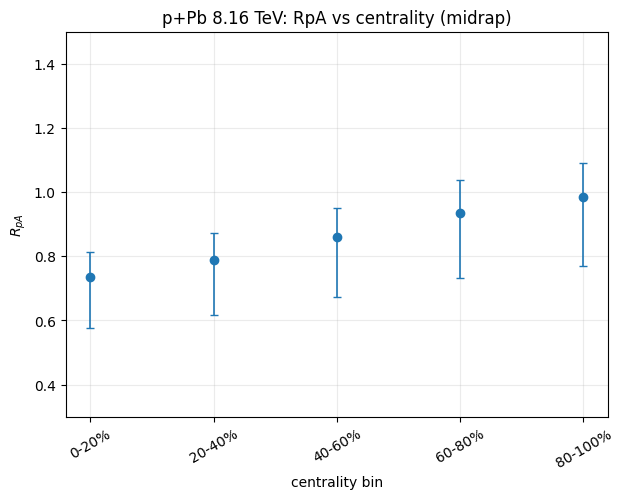

In [32]:
#  5.02 TeV vs 8 (correct σNN)
tab5_mid = rpa_vs_cent_table(model5, rgrid5, sys5.df_pa, (-1.93, 1.93), 2.5, 20.0, out5, "p+Pb 5.02 TeV", "midrap",   sigmaNN_mb5)
tab8_mid = rpa_vs_cent_table(model8, rgrid8, sys8.df_pa, (-1.93, 1.93), 2.5, 20.0, out8, "p+Pb 8.16 TeV", "midrap",   sigmaNN_mb8)

[rpa_vs_centrality_integrated] window: y∈[2.5,4.0], pT∈[2.5,20.0]
  bin 0-20%: alpha=0.922964, points=105, wsum=9.109e+01
  bin 20-40%: alpha=0.741329, points=105, wsum=9.109e+01
  bin 40-60%: alpha=0.501566, points=105, wsum=9.109e+01
  bin 60-80%: alpha=0.234338, points=105, wsum=9.109e+01
  bin 80-100%: alpha=0.053286, points=105, wsum=9.109e+01


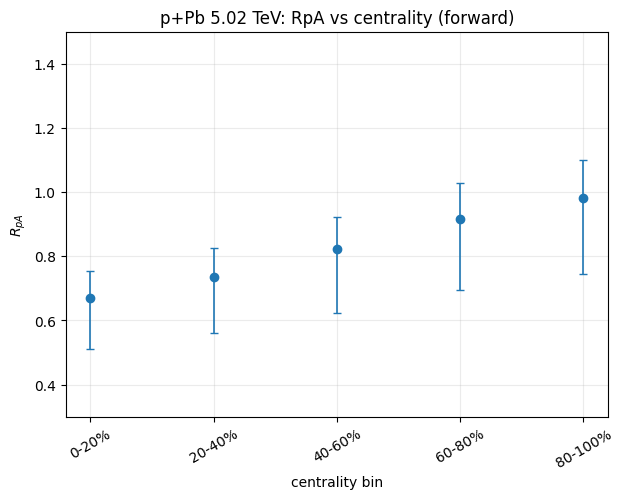

[rpa_vs_centrality_integrated] window: y∈[2.5,4.0], pT∈[2.5,20.0]
  bin 0-20%: alpha=0.922023, points=105, wsum=1.338e+02
  bin 20-40%: alpha=0.738454, points=105, wsum=1.338e+02
  bin 40-60%: alpha=0.493996, points=105, wsum=1.338e+02
  bin 60-80%: alpha=0.224855, points=105, wsum=1.338e+02
  bin 80-100%: alpha=0.050273, points=105, wsum=1.338e+02


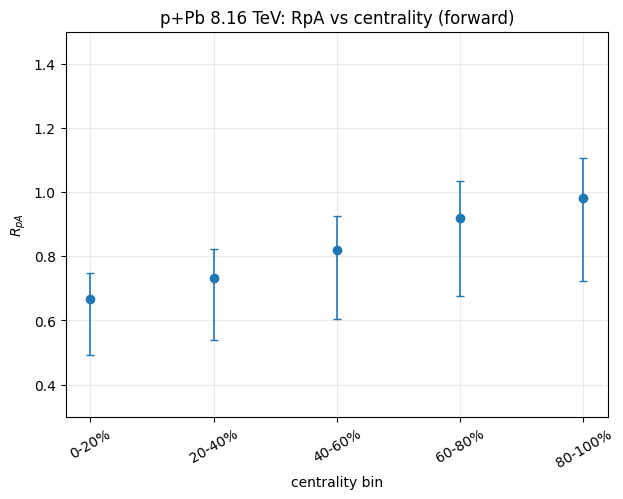

In [33]:
## 5 vs 8
tab5_fwd = rpa_vs_cent_table(model5, rgrid5, sys5.df_pa, ( 2.50, 4.00), 2.5, 20.0, out5, "p+Pb 5.02 TeV", "forward",  sigmaNN_mb5)
tab8_fwd = rpa_vs_cent_table(model8, rgrid8, sys8.df_pa, ( 2.50, 4.00), 2.5, 20.0, out8, "p+Pb 8.16 TeV", "forward",  sigmaNN_mb8)

[rpa_vs_centrality_integrated] window: y∈[-5.0,-2.5], pT∈[2.5,20.0]
  bin 0-20%: alpha=0.922964, points=175, wsum=1.720e+02
  bin 20-40%: alpha=0.741329, points=175, wsum=1.720e+02
  bin 40-60%: alpha=0.501566, points=175, wsum=1.720e+02
  bin 60-80%: alpha=0.234338, points=175, wsum=1.720e+02
  bin 80-100%: alpha=0.053286, points=175, wsum=1.720e+02


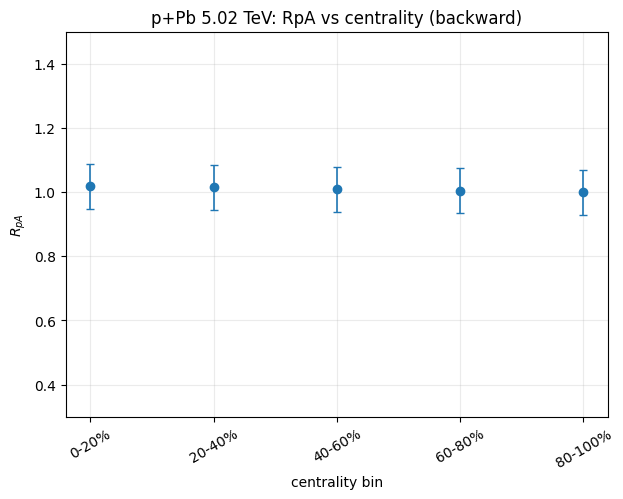

[rpa_vs_centrality_integrated] window: y∈[-5.0,-2.5], pT∈[2.5,20.0]
  bin 0-20%: alpha=0.922023, points=175, wsum=2.549e+02
  bin 20-40%: alpha=0.738454, points=175, wsum=2.549e+02
  bin 40-60%: alpha=0.493996, points=175, wsum=2.549e+02
  bin 60-80%: alpha=0.224855, points=175, wsum=2.549e+02
  bin 80-100%: alpha=0.050273, points=175, wsum=2.549e+02


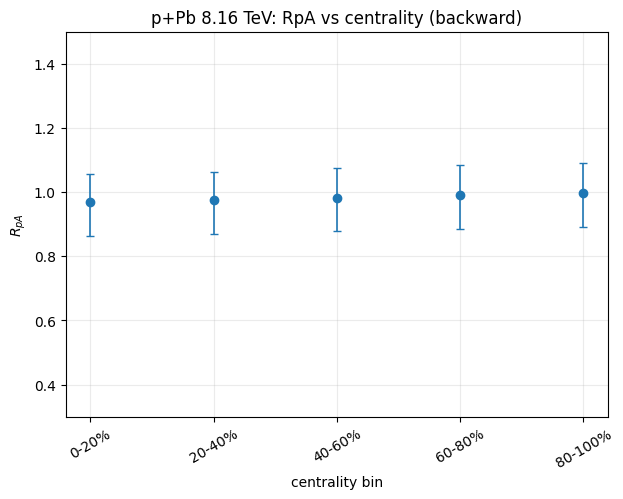

In [34]:
# 5 vs 8 back
tab5_bwd = rpa_vs_cent_table(model5, rgrid5, sys5.df_pa, (-5.00,-2.50), 2.5, 20.0, out5, "p+Pb 5.02 TeV", "backward", sigmaNN_mb5)
tab8_bwd = rpa_vs_cent_table(model8, rgrid8, sys8.df_pa, (-5.00,-2.50), 2.5, 20.0, out5, "p+Pb 8.16 TeV", "backward", sigmaNN_mb8)

### Comparison Panels

In [35]:
def rpa_vs_centrality_multi_y(model, rgrid, pa_df, y_windows, ptmin, ptmax,
                              out_dir, tag, names=None, ylim=(0.3, 1.3)):
    """
    y_windows: list of (ymin, ymax)
    names:     list of labels for legend/panel titles (same length as y_windows)
    """
    if names is None:
        names = [f"y∈[{a},{b}]" for (a,b) in y_windows]

    tables = []
    for (ymin, ymax), nm in zip(y_windows, names):
        tab = model.rpa_vs_centrality_integrated(
            rgrid, pa_df, cent_edges,
            y_min=ymin, y_max=ymax, pt_min=ptmin, pt_max=ptmax,
            sigmaNN_mb=sigmaNN_mb5, weight="inelastic", verbose=True
        )
        if tab.empty:
            print(f"[warn] empty table for {nm}")
        tab.to_csv(os.path.join(out_dir, f"RpA_vs_centrality_{nm.replace(' ','_')}_pt{ptmin}to{ptmax}.csv"),
                   index=False)
        tables.append((nm, tab))

    # (1) Side-by-side small multiples (one panel per y-window)
    fig, axes = plt.subplots(1, len(tables), figsize=(5.6*len(tables), 4.2),
                             sharey=True, constrained_layout=True)
    axes = np.atleast_1d(axes)
    for ax, (nm, tab) in zip(axes, tables):
        if tab.empty: ax.set_visible(False); continue
        xs = np.arange(len(tab))
        y  = tab["r_central"].to_numpy()
        ylo = y - tab["r_lo"].to_numpy()
        yhi = tab["r_hi"].to_numpy() - y
        ax.errorbar(xs, y, yerr=[ylo, yhi], fmt="o", capsize=3, lw=1.2)
        ax.set_xticks(xs, tab["cent_bin"])
        style_axes(ax, "centrality bin", r"$R_{pA}$", title=nm)
        ax.set_ylim(*ylim); plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
    fig.suptitle(f"{tag}: RpA vs centrality — side-by-side by y-window")
    plt.show()

    # # (2) Single overlay (y-window as legend)
    # fig, ax = plt.subplots()
    # for nm, tab in tables:
    #     if tab.empty: continue
    #     xs = np.arange(len(tab))
    #     y  = tab["r_central"].to_numpy()
    #     ylo = y - tab["r_lo"].to_numpy()
    #     yhi = tab["r_hi"].to_numpy() - y
    #     ax.errorbar(xs, y, yerr=[ylo, yhi], fmt="o-", capsize=3, lw=1.2, label=nm)
    # if tables and not tables[0][1].empty:
    #     ax.set_xticks(np.arange(len(tables[0][1])), tables[0][1]["cent_bin"])
    # style_axes(ax, "centrality bin", r"$R_{pA}$", title=f"{tag}: RpA vs centrality (overlay)")
    # ax.set_ylim(*ylim); plt.xticks(rotation=30); ax.legend(title="y-window")
    # plt.show()

[rpa_vs_centrality_integrated] window: y∈[-1.93,1.93], pT∈[2.5,20.0]
  bin 0-20%: alpha=0.922964, points=280, wsum=3.587e+02
  bin 20-40%: alpha=0.741329, points=280, wsum=3.587e+02
  bin 40-60%: alpha=0.501566, points=280, wsum=3.587e+02
  bin 60-80%: alpha=0.234338, points=280, wsum=3.587e+02
  bin 80-100%: alpha=0.053286, points=280, wsum=3.587e+02
[rpa_vs_centrality_integrated] window: y∈[1.5,4.0], pT∈[2.5,20.0]
  bin 0-20%: alpha=0.922964, points=175, wsum=1.701e+02
  bin 20-40%: alpha=0.741329, points=175, wsum=1.701e+02
  bin 40-60%: alpha=0.501566, points=175, wsum=1.701e+02
  bin 60-80%: alpha=0.234338, points=175, wsum=1.701e+02
  bin 80-100%: alpha=0.053286, points=175, wsum=1.701e+02
[rpa_vs_centrality_integrated] window: y∈[-4.0,-2.5], pT∈[2.5,20.0]
  bin 0-20%: alpha=0.922964, points=105, wsum=1.206e+02
  bin 20-40%: alpha=0.741329, points=105, wsum=1.206e+02
  bin 40-60%: alpha=0.501566, points=105, wsum=1.206e+02
  bin 60-80%: alpha=0.234338, points=105, wsum=1.206e+02


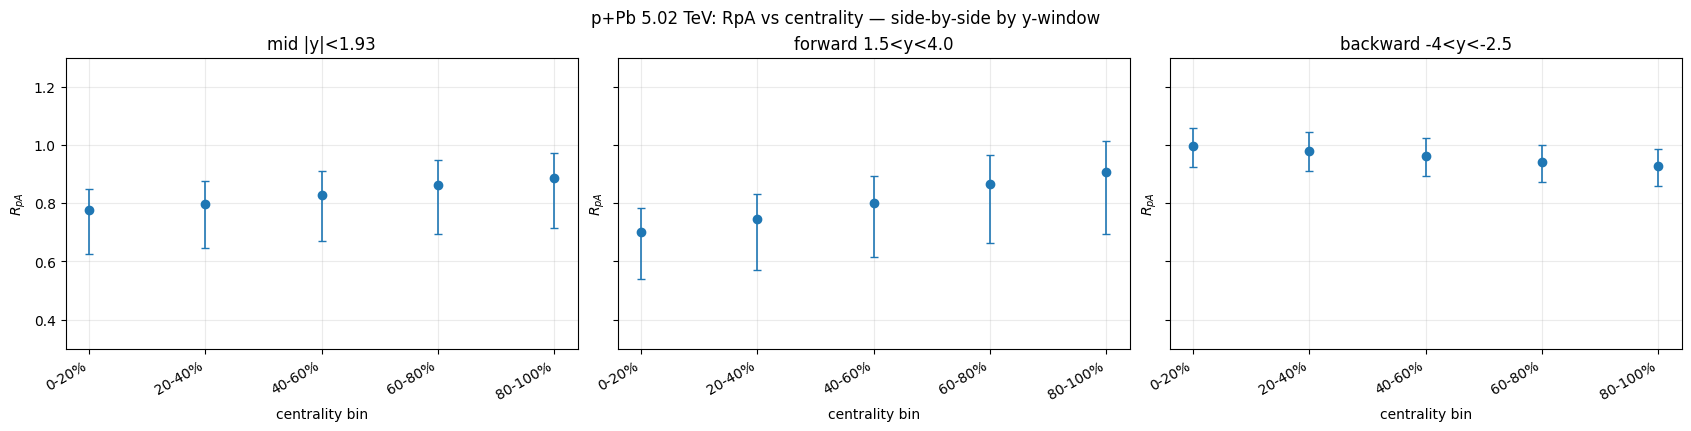

In [ ]:
# Side-by-side AND overlay for three y regions
ywins = [(-1.93, 1.93), (1.5, 4.0), (-5.0, -2.5)]
names = ["mid |y|<1.93", "forward 1.5<y<4.0", "backward -5<y<-2.5"]
rpa_vs_centrality_multi_y(model5, rgrid5, sys5.df_pa, ywins, 2.5, 20.0, out5, "p+Pb 5.02 TeV", names)

## RpA vs Rapidity

### All Overlap

  0-20%: y-bins=20 (Δy=0.5)
  20-40%: y-bins=20 (Δy=0.5)
  40-60%: y-bins=20 (Δy=0.5)
  60-80%: y-bins=20 (Δy=0.5)
  80-100%: y-bins=20 (Δy=0.5)


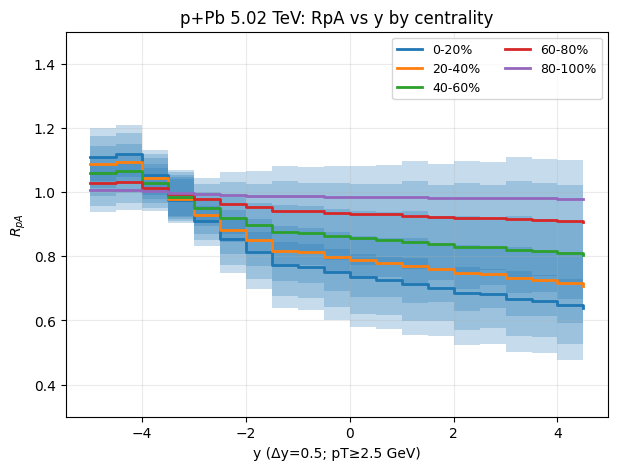

In [36]:
# 5) RpA vs y in centrality bins (Δy=0.5)
def rpa_vs_y_plot(model, rgrid, pa_df, out_dir, tag, sigmaNN_mb):
    bands = model.rpa_vs_y_in_centrality_bins(
        rgrid, pa_df, cent_edges, y_width=0.5, pt_min=2.5,
        sigmaNN_mb=sigmaNN_mb, weight="inelastic", verbose=True
    )
    fig, ax = plt.subplots()
    for label, df in bands:
        if df.empty: continue
        df.to_csv(os.path.join(out_dir, f"RpA_vs_y_{label.replace('%','pct')}.csv"), index=False)
        step_band_xy(ax, df["y_left"], df["r_central"], df["r_lo"], df["r_hi"], label=label)
    style_axes(ax, "y (Δy=0.5; pT≥2.5 GeV)", r"$R_{pA}$", title=f"{tag}: RpA vs y by centrality")
    ax.set_ylim(0.3, 1.5); ax.legend(ncols=2, fontsize=9); plt.show()

rpa_vs_y_plot(model5, rgrid5, sys5.df_pa, out5, "p+Pb 5.02 TeV",sigmaNN_mb=sigmaNN_mb5)

### RpA vs y Panel Comparison

In [37]:
def rpa_vs_y_subfigs(model, rgrid, pa_df, cent_edges,
                     y_width=0.5, pt_min=2.5,
                     sigmaNN_mb=70.0, weight="inelastic",
                     ncols=3, ylim=(0.3, 1.5),
                     tag="p+Pb 5.02 TeV", out_dir=None, save_basename=None,
                     annotate_npart=True, verbose=True):
    """
    Make side-by-side subplots of RpA vs y (Δy bins), one panel per centrality.
    Uses step bands with left-edge x-values.
    """
    # compute bands once (your existing call)
    bands = model.rpa_vs_y_in_centrality_bins(
        rgrid, pa_df, cent_edges, y_width=y_width, pt_min=pt_min,
        sigmaNN_mb=sigmaNN_mb, weight=weight, verbose=verbose
    )

    # optional: centrality meta for ⟨N_part⟩ annotations
    npart_map = {}
    if annotate_npart and hasattr(model, "centrality_table"):
        ctab = model.centrality_table(cent_edges, sigmaNN_mb=sigmaNN_mb)
        npart_map = {row["cent_bin"]: row["N_part"] for _, row in ctab.iterrows()}

    # keep only non-empty
    bands = [(lab, df.copy()) for (lab, df) in bands if not df.empty]
    if not bands:
        print("[warn] no bands to plot"); return

    # layout
    n = len(bands)
    ncols = min(ncols, n)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5.2*ncols, 3.8*nrows),
                             sharex=True, sharey=True, constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    # draw panels
    for ax, (label, df) in zip(axes, bands):
        # optional CSV dump for this bin
        if out_dir:
            df.to_csv(os.path.join(out_dir, f"RpA_vs_y_{label.replace('%','pct')}.csv"), index=False)

        # step band uses y_left as the x (left-edge of Δy bins)
        step_band_xy(ax, df["y_left"], df["r_central"], df["r_lo"], df["r_hi"])
        # title with ⟨N_part⟩ if available
        ttl = label
        if label in npart_map:
            ttl = f"Centrality: {label})"
        style_axes(ax, "y (pT≥{:.1f} GeV)".format(pt_min), r"$R_{pA}$", title=ttl)
        if ylim: ax.set_ylim(*ylim)

    # hide unused slots
    for ax in axes[len(bands):]:
        ax.axis("off")

    fig.suptitle(f"{tag}: $R_{{pA}}$ vs $y$ — per centrality", y=1.02)

    # optional save
    if out_dir and save_basename:
        fn = os.path.join(out_dir, f"{save_basename}.pdf")
        fig.savefig(fn, bbox_inches="tight")
        if verbose: print(f"[save] {fn}")

    plt.show()

  0-20%: y-bins=20 (Δy=0.5)
  20-40%: y-bins=20 (Δy=0.5)
  40-60%: y-bins=20 (Δy=0.5)
  60-80%: y-bins=20 (Δy=0.5)
  80-100%: y-bins=20 (Δy=0.5)
[save] ./output-5.02-centrality/RpA_vs_y_by_centrality.pdf


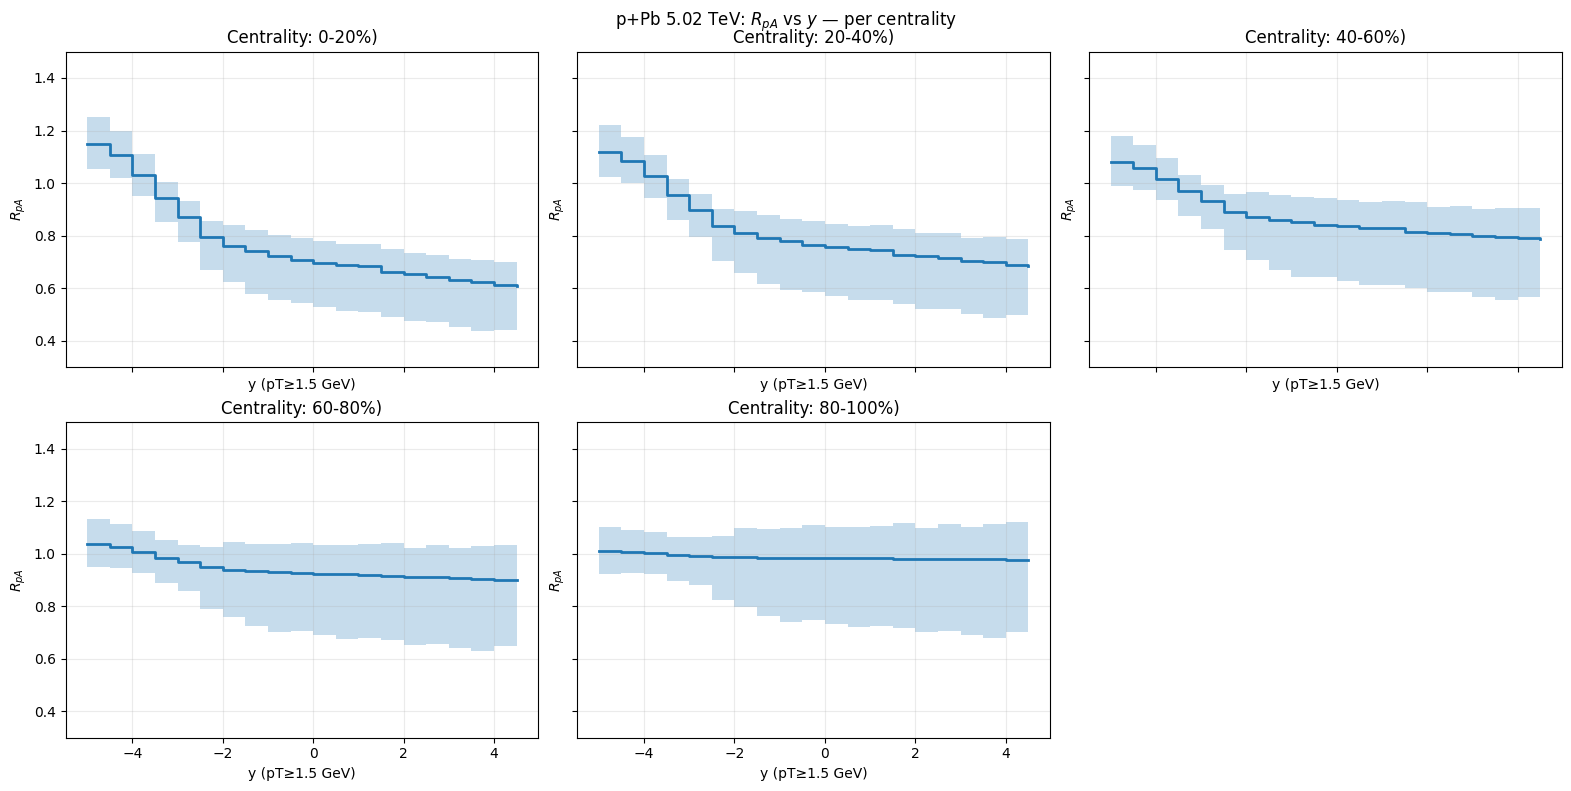

In [38]:
# side-by-side subplots (one per centrality)
rpa_vs_y_subfigs(
    model5, rgrid5, sys5.df_pa, cent_edges,
    y_width=0.5, pt_min=1.5,
    sigmaNN_mb=sigmaNN_mb5, weight="inelastic",
    ncols=3, ylim=(0.3, 1.5),
    tag="p+Pb 5.02 TeV",
    out_dir=out5, save_basename="RpA_vs_y_by_centrality",
    annotate_npart=True, verbose=True
)

## RpA vs Transverse Momentum

### All Overlapping

In [39]:
def _plot_vs_pt(ywin, name):
    bands = model5.rpa_vs_pt_in_centrality_bins(rgrid5, sys5.df_pa,
                                                cent_edges, y_min=ywin[0], y_max=ywin[1], pt_width=2.5,
                                                sigmaNN_mb=sigmaNN_mb5, weight="inelastic", verbose=True)
    fig, ax = plt.subplots()
    for label, df in bands:
        if df.empty: continue
        df = df[df["pt_left"] <= 20.0]
        band_xy(ax, df["pt"], df["r_central"], df["r_lo"], df["r_hi"], label=label)
    style_axes(ax, r"$p_T$ [GeV]", r"$R_{pA}$", title=f"p+Pb 5.02 TeV: RpA vs pT ({name}) by centrality")
    ax.set_xlim(0,20); ax.set_ylim(0.0,1.3); ax.legend(ncols=2); plt.show()

  0-20%: pT-bins=20 in y∈[-1.93,1.93] (ΔpT=2.5)
  20-40%: pT-bins=20 in y∈[-1.93,1.93] (ΔpT=2.5)
  40-60%: pT-bins=20 in y∈[-1.93,1.93] (ΔpT=2.5)
  60-80%: pT-bins=20 in y∈[-1.93,1.93] (ΔpT=2.5)
  80-100%: pT-bins=20 in y∈[-1.93,1.93] (ΔpT=2.5)


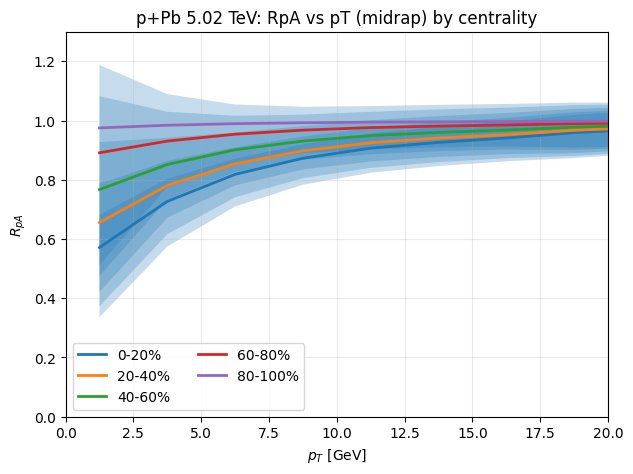

In [40]:
_plot_vs_pt((-1.93, 1.93), "midrap")

  0-20%: pT-bins=20 in y∈[1.5,4.0] (ΔpT=2.5)
  20-40%: pT-bins=20 in y∈[1.5,4.0] (ΔpT=2.5)
  40-60%: pT-bins=20 in y∈[1.5,4.0] (ΔpT=2.5)
  60-80%: pT-bins=20 in y∈[1.5,4.0] (ΔpT=2.5)
  80-100%: pT-bins=20 in y∈[1.5,4.0] (ΔpT=2.5)


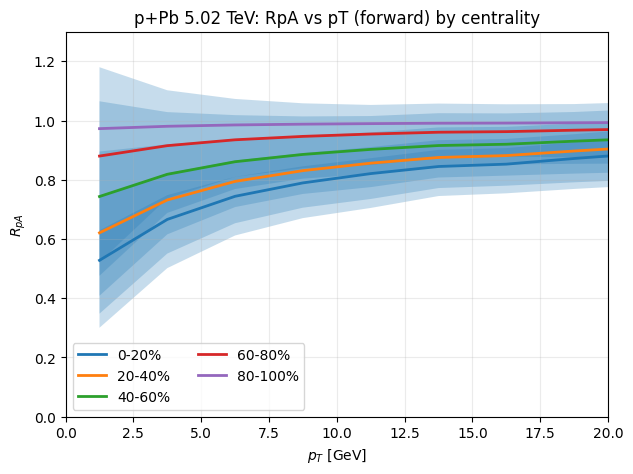

In [41]:
_plot_vs_pt(( 1.5 , 4.0 ), "forward")

  0-20%: pT-bins=20 in y∈[-4.0,-2.5] (ΔpT=2.5)
  20-40%: pT-bins=20 in y∈[-4.0,-2.5] (ΔpT=2.5)
  40-60%: pT-bins=20 in y∈[-4.0,-2.5] (ΔpT=2.5)
  60-80%: pT-bins=20 in y∈[-4.0,-2.5] (ΔpT=2.5)
  80-100%: pT-bins=20 in y∈[-4.0,-2.5] (ΔpT=2.5)


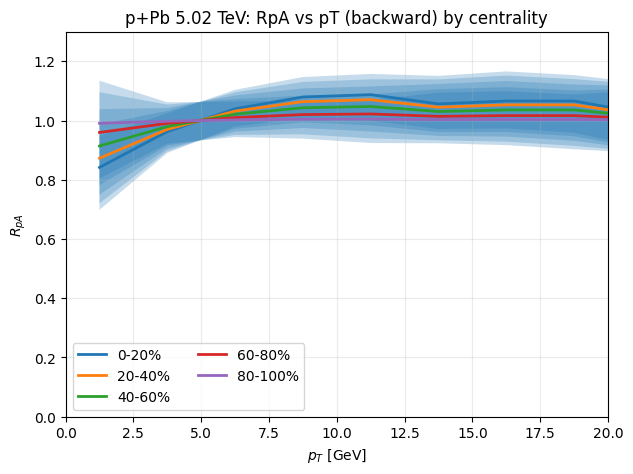

In [42]:
_plot_vs_pt((-4.0 , -2.5), "backward")

### Comparison

In [43]:
def rpa_vs_pt_subfigs(model, rgrid, pa_df, cent_edges, ywin,
                      pt_width=2.5, pt_max=20.0,
                      sigmaNN_mb=70.0, weight="inelastic",
                      ncols=3, ylim=(0.3, 1.3),
                      tag="p+Pb 5.02 TeV", out_dir=None, save_basename=None,
                      annotate_npart=True, verbose=True):
    """
    Side-by-side subplots of RpA vs pT (ΔpT bins) for a fixed y-window, one panel per centrality.
    Uses band_xy with pT BIN CENTERS as x.
    """
    # compute once (same call as your overlap plot)
    bands = model.rpa_vs_pt_in_centrality_bins(
        rgrid, pa_df, cent_edges,
        y_min=ywin[0], y_max=ywin[1], pt_width=pt_width,
        sigmaNN_mb=sigmaNN_mb, weight=weight, verbose=verbose
    )

    # optional: ⟨N_part⟩ annotations
    npart_map = {}
    if annotate_npart and hasattr(model, "centrality_table"):
        ctab = model.centrality_table(cent_edges, sigmaNN_mb=sigmaNN_mb)
        npart_map = {row["cent_bin"]: row["N_part"] for _, row in ctab.iterrows()}

    # keep only non-empty, trim pT range
    bands = [(lab, df[df["pt_left"] <= pt_max].copy()) for (lab, df) in bands if not df.empty]
    if not bands:
        print("[warn] no centrality bands to plot"); return

    # layout
    n = len(bands)
    ncols = min(ncols, n)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5.2*ncols, 3.8*nrows),
                             sharex=True, sharey=True, constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    # draw panels
    for ax, (label, df) in zip(axes, bands):
        # optional CSV dump per bin
        if out_dir:
            df.to_csv(os.path.join(out_dir,
                                   f"RpA_vs_pT_{label.replace('%','pct')}_y{ywin[0]}to{ywin[1]}_dpt{pt_width}.csv"),
                      index=False)

        band_xy(ax, df["pt"], df["r_central"], df["r_lo"], df["r_hi"])
        ttl = label
        if label in npart_map:
            ttl = f"Centrality: {label}"
        style_axes(ax, r"$p_T$ [GeV]", r"$R_{pA}$", title=ttl)
        ax.set_xlim(0, pt_max)
        if ylim: ax.set_ylim(*ylim)

    # hide unused slots
    for ax in axes[len(bands):]:
        ax.axis("off")

    fig.suptitle(f"{tag}: $R_{{pA}}$ vs $p_T$ — per centrality,  {ywin[0]}<y<{ywin[1]} (Δ$p_T$={pt_width} GeV)",
                 y=1.02)

    # optional save
    if out_dir and save_basename:
        fn = os.path.join(out_dir, f"{save_basename}_y{ywin[0]}to{ywin[1]}_dpt{pt_width}.pdf")
        fig.savefig(fn, bbox_inches="tight")
        if verbose: print(f"[save] {fn}")

    plt.show()

  0-20%: pT-bins=20 in y∈[-1.93,1.93] (ΔpT=2.5)
  20-40%: pT-bins=20 in y∈[-1.93,1.93] (ΔpT=2.5)
  40-60%: pT-bins=20 in y∈[-1.93,1.93] (ΔpT=2.5)
  60-80%: pT-bins=20 in y∈[-1.93,1.93] (ΔpT=2.5)
  80-100%: pT-bins=20 in y∈[-1.93,1.93] (ΔpT=2.5)
[save] ./output-5.02-centrality/RpA_vs_pT_by_centrality_mid_y-1.93to1.93_dpt2.5.pdf


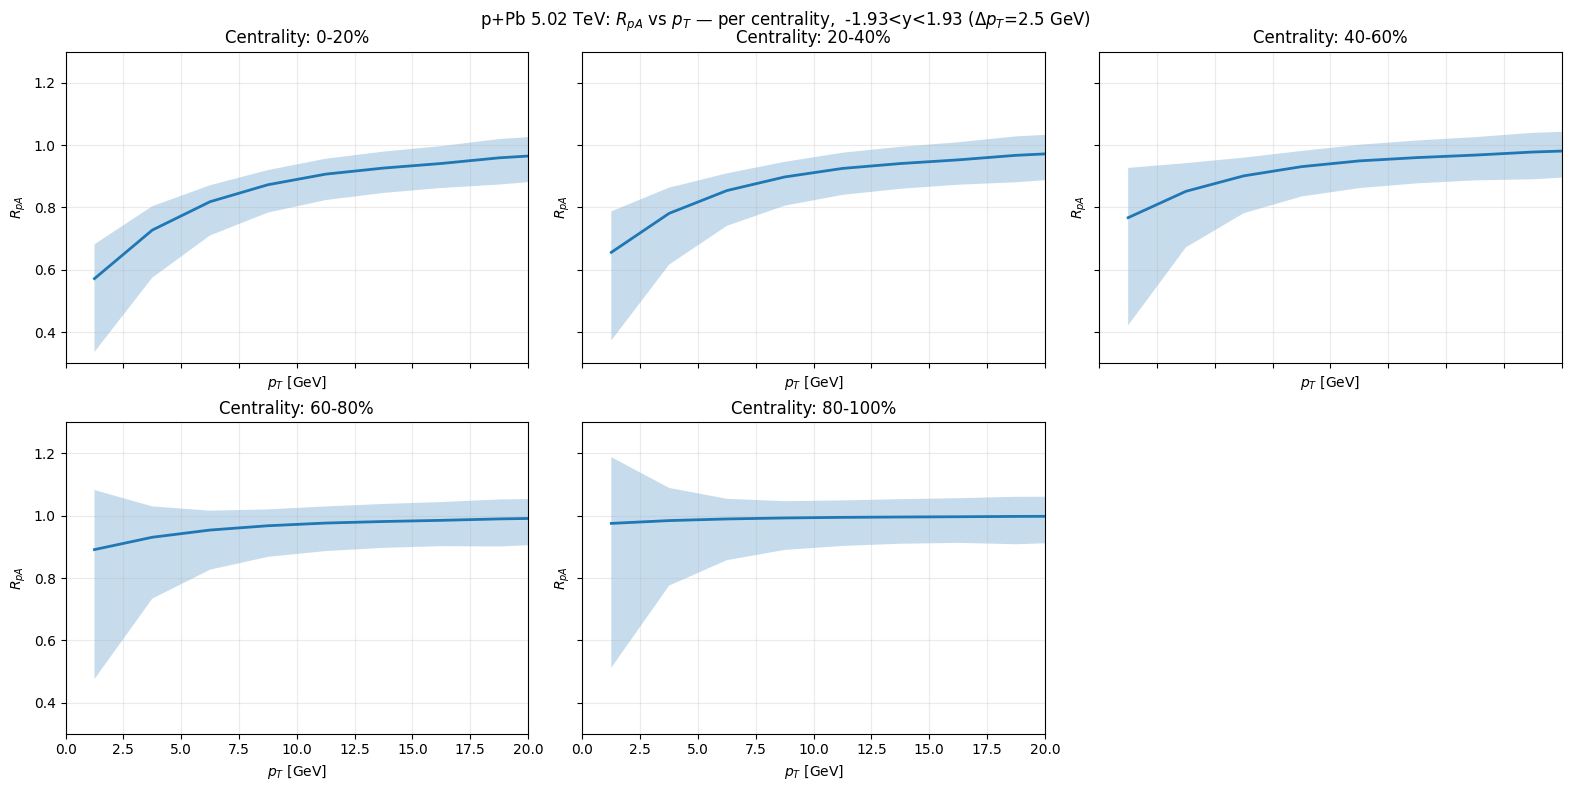

In [44]:
# add subfigs (one panel per centrality), same numbers:
rpa_vs_pt_subfigs(model5, rgrid5, sys5.df_pa, cent_edges,
                  ywin=(-1.93, 1.93), pt_width=2.5, pt_max=20.0,
                  sigmaNN_mb=sigmaNN_mb5, weight="inelastic",
                  ncols=3, ylim=(0.3, 1.3),
                  tag="p+Pb 5.02 TeV", out_dir=out5,
                  save_basename="RpA_vs_pT_by_centrality_mid",
                  annotate_npart=True, verbose=True)

  0-20%: pT-bins=20 in y∈[1.5,4.0] (ΔpT=2.5)
  20-40%: pT-bins=20 in y∈[1.5,4.0] (ΔpT=2.5)
  40-60%: pT-bins=20 in y∈[1.5,4.0] (ΔpT=2.5)
  60-80%: pT-bins=20 in y∈[1.5,4.0] (ΔpT=2.5)
  80-100%: pT-bins=20 in y∈[1.5,4.0] (ΔpT=2.5)
[save] ./output-5.02-centrality/RpA_vs_pT_by_centrality_forward_y1.5to4.0_dpt2.5.pdf


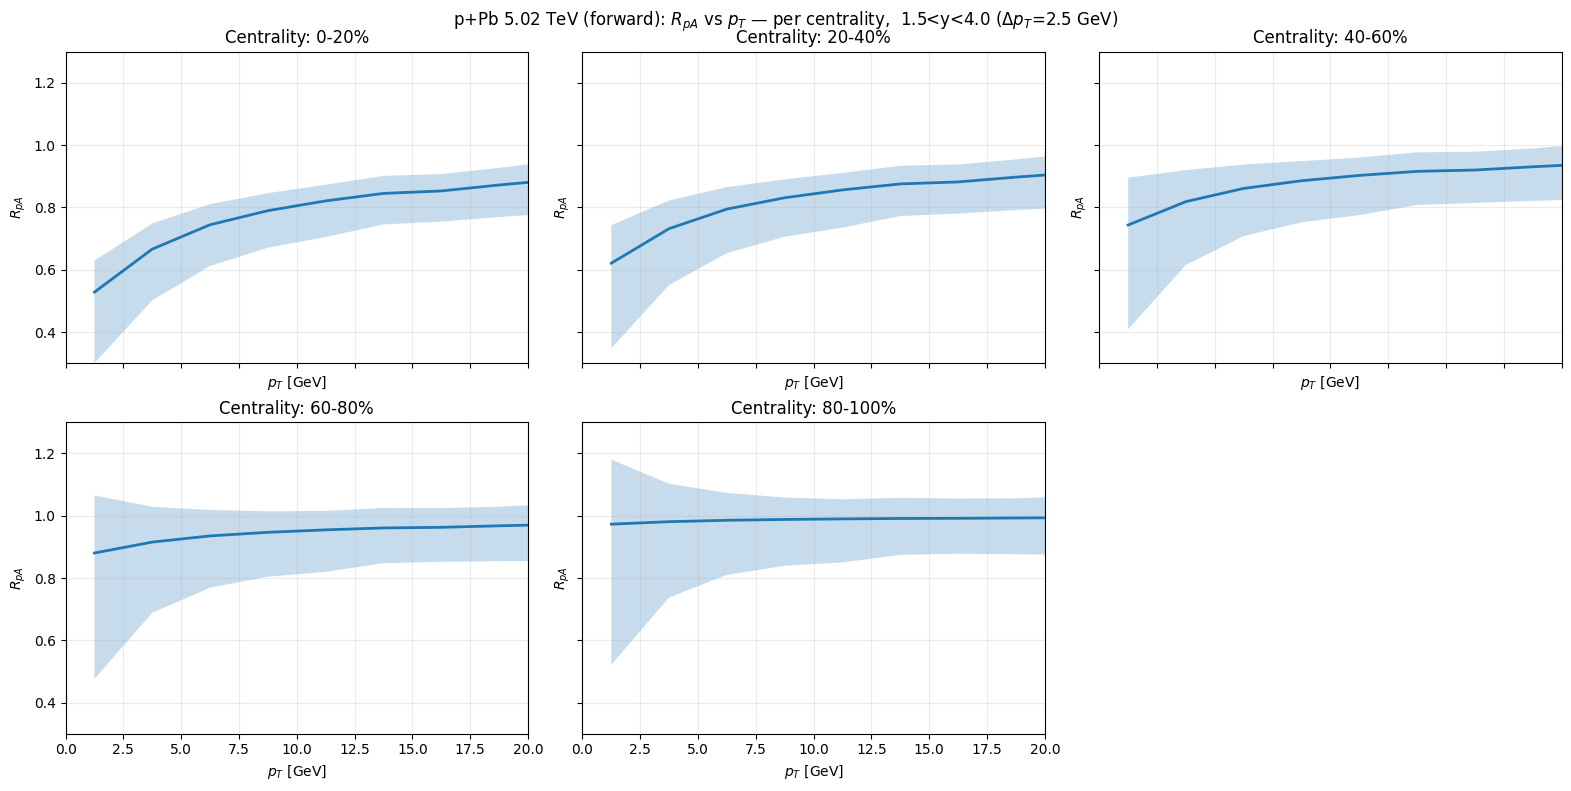

  0-20%: pT-bins=20 in y∈[-5.0,-2.5] (ΔpT=2.5)
  20-40%: pT-bins=20 in y∈[-5.0,-2.5] (ΔpT=2.5)
  40-60%: pT-bins=20 in y∈[-5.0,-2.5] (ΔpT=2.5)
  60-80%: pT-bins=20 in y∈[-5.0,-2.5] (ΔpT=2.5)
  80-100%: pT-bins=20 in y∈[-5.0,-2.5] (ΔpT=2.5)
[save] ./output-5.02-centrality/RpA_vs_pT_by_centrality_backward_y-5.0to-2.5_dpt2.5.pdf


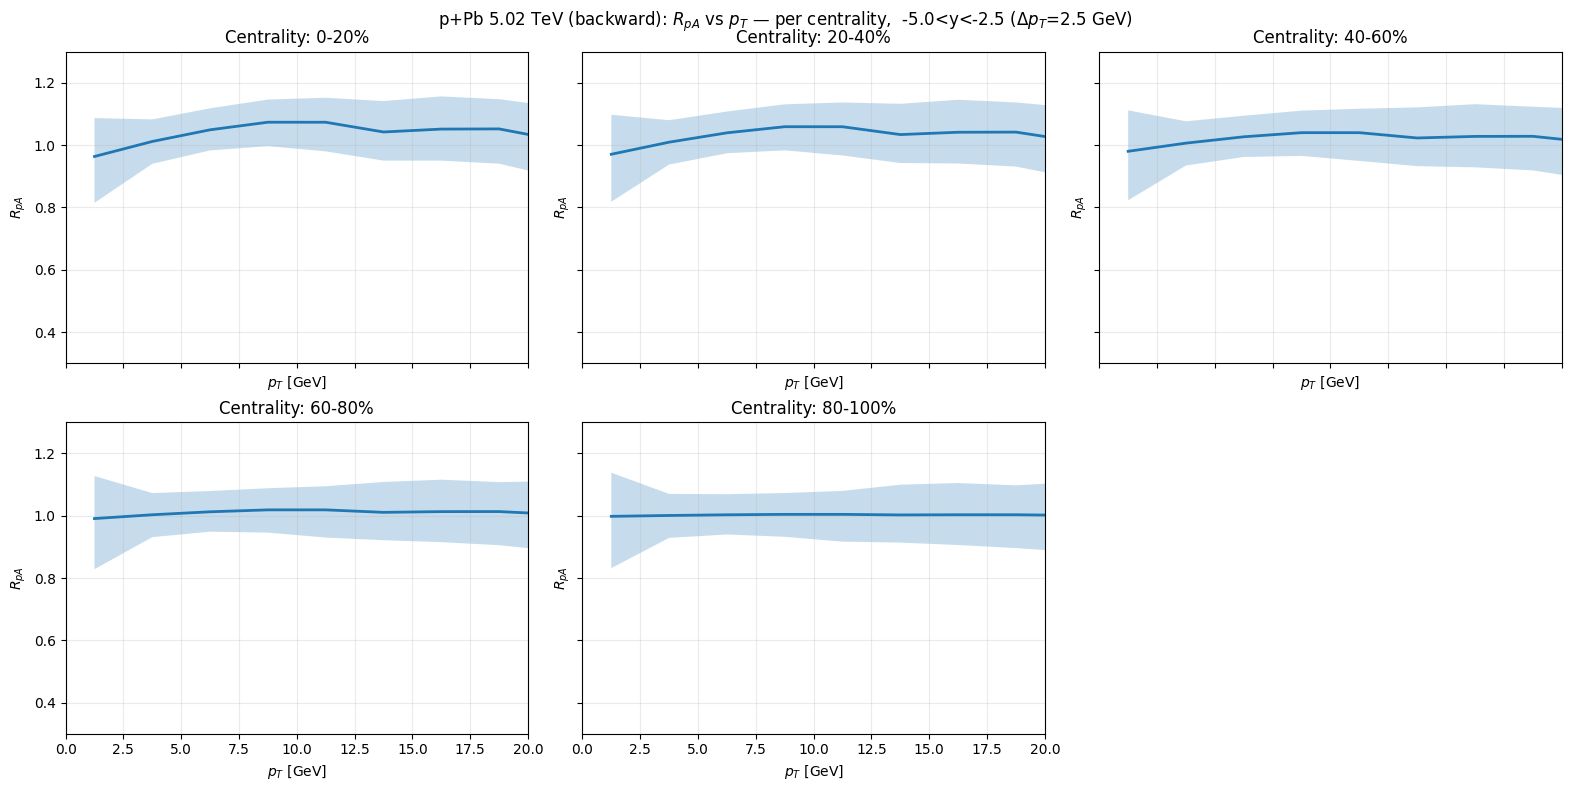

In [45]:
# forward/backward too:
for ywin, name in [((1.5, 4.0), "forward"), ((-5.0, -2.5), "backward")]:
    rpa_vs_pt_subfigs(model5, rgrid5, sys5.df_pa, cent_edges,
                      ywin=ywin, pt_width=2.5, pt_max=20.0,
                      sigmaNN_mb=sigmaNN_mb5, weight="inelastic",
                      ncols=3, ylim=(0.3, 1.3),
                      tag=f"p+Pb 5.02 TeV ({name})", out_dir=out5,
                      save_basename=f"RpA_vs_pT_by_centrality_{name}",
                      annotate_npart=True, verbose=True)